In [2]:
# ! pip install astropy & grizli if needed

In [3]:
%matplotlib inline

import os
import yaml

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import astropy.io.fits as pyfits
from astropy.io import fits
from astropy.table import Table

import grizli
import grizli.catalog
from grizli import utils

import eazy

print(f'grizli version: {grizli.__version__}')
print(f'eazy-py version: {eazy.__version__}')

Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git
grizli version: 1.11.1
eazy-py version: 0.6.8


### Set field & path
`abell2744clu` = Abell 2744 GLASS + UNCOVER + DD-2756

In [4]:
field = 'abell2744clu-grizli-v7.0'
url_path = 'https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7'

### FITS file

In [5]:
hdu_list = fits.open('abell2744clu-grizli-v7.0_phot.fits')
hdu_list.info()
print(hdu_list[1].columns)

Filename: abell2744clu-grizli-v7.0_phot.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU   2242   47888R x 601C   [J, D, K, K, K, K, K, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, K, K, K, K, K, D, D, J, D, D, D, D, D, D, K, D, D, D, D, D, D, K, D, I, D, D, D, D, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, D, I, D, D, D, D, I, D, D, D, D, I, D, D, D, D, 

Text(0, 0.5, 'y')

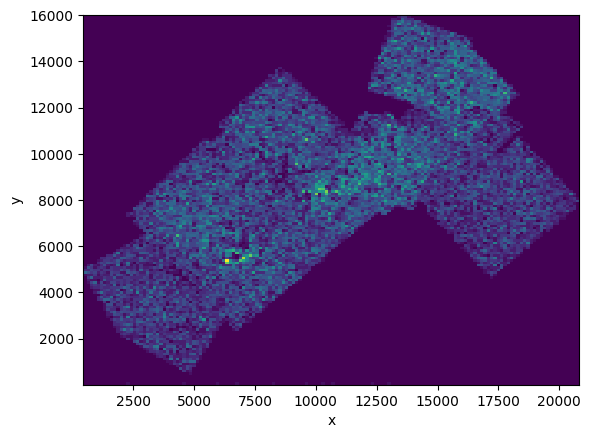

In [6]:
data = Table(hdu_list[1].data)

plt.hist2d(data['x'], data['y'], bins=(150, 150))
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

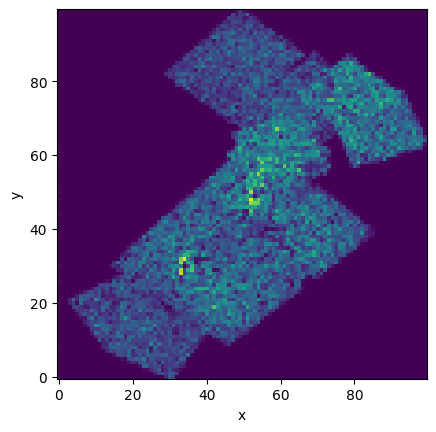

In [7]:
img, x, y = np.histogram2d(data['x'], data['y'], bins=(100, 100))

plt.imshow(img, cmap='viridis', origin='lower')

plt.xlabel('x')
plt.ylabel('y')

## Raw photometry

NB: All photometry given in `fnu` flux densities with units of `microJansky` (AB zeropoint = 23.9).

In [8]:
phot = utils.read_catalog(f'{url_path}/{field}_phot.fits')
print(type(phot))
phot.columns

<class 'grizli.utils.GTable'>


<TableColumns names=('id','thresh','npix','tnpix','xmin','xmax','ymin','ymax','x','y','x2_image','y2_image','xy_image','errx2','erry2','errxy','a_image','b_image','theta_image','cxx_image','cyy_image','cxy_image','cflux','flux','cpeak','peak','xcpeak','ycpeak','xpeak','ypeak','flag','x_image','y_image','number','ra','dec','x_world','y_world','flux_iso','fluxerr_iso','area_iso','mag_iso','kron_radius','kron_rcirc','flux_auto','fluxerr_auto','bkg_auto','flag_auto','area_auto','flux_radius_flag','flux_radius_20','flux_radius','flux_radius_90','tot_corr','mag_auto','magerr_auto','flux_aper_0','fluxerr_aper_0','flag_aper_0','bkg_aper_0','mask_aper_0','flux_aper_1','fluxerr_aper_1','flag_aper_1','bkg_aper_1','mask_aper_1','flux_aper_2','fluxerr_aper_2','flag_aper_2','bkg_aper_2','mask_aper_2','flux_aper_3','fluxerr_aper_3','flag_aper_3','bkg_aper_3','mask_aper_3','clearp-f356w_flux_aper_0','clearp-f356w_fluxerr_aper_0','clearp-f356w_flag_aper_0','clearp-f356w_bkg_aper_0','clearp-f356w_mask_a

### Metadata

In [9]:
# General data of source detection
for i, k in enumerate(phot.meta):
    print(f'{k:>36} = {phot.meta[k]}')
    if i > 70:
        print('...')
        break

                             VERSION = 1.2.1
                             MINAREA = 9
                               CLEAN = True
                             DEBCONT = 0.001
                            DEBTHRSH = 32
                         FILTER_TYPE = conv
                           THRESHOLD = 1.5
                            KRONFACT = 2.5
                               KRON0 = 2.4
                               KRON1 = 3.8
                             MINKRON = 8.75000000000009
                            TOTCFILT = F140W
                            TOTCWAVE = 13922.907
                                  ZP = 28.9
                                PLAM = 13922.907
                                 FNU = 1e-08
                                FLAM = 1.4737148e-20
                              UJY2DN = 99.99395614709495
                            DRZ_FILE = abell2744clu-grizli-v7.0-ir_drc_sci.
                            WHT_FILE = abell2744clu-grizli-v7.0-ir_drc_wht.
                 

### Photometric apertures

In [13]:
for i, k in enumerate(phot.meta):
    if k.startswith('APER_'):
        aper_index = k[-1]
        print(f"Aperture index {aper_index}: *diameter* = {phot.meta[k]:4.1f} pixels = {phot.meta[k.replace('APER','ASEC')]:.2f} arcsec")

# Some observers use large apertures for their measurements to account for seeing, tracking, 
# and focus variations, while others use small apertures and apply aperture corrections (how do we choose here?)

Aperture index 0: *diameter* =  9.0 pixels = 0.36 arcsec
Aperture index 1: *diameter* = 12.5 pixels = 0.50 arcsec
Aperture index 2: *diameter* = 17.5 pixels = 0.70 arcsec
Aperture index 3: *diameter* = 25.0 pixels = 1.00 arcsec


In [43]:
# Columns for a particular filter + aperture
# bands in the HFF survey that cover the optical-IR: F435, F606, F814, F105, F140

aper_index = '2' 

cols = []

for k in phot.colnames:
    if k.startswith('f606w') & k.endswith(aper_index):
        cols.append(k)
        
phot[cols].info()

<GTable length=47888>
        name          dtype  unit    class     n_bad
-------------------- ------- ---- ------------ -----
   f606w_flux_aper_2 float64  uJy MaskedColumn  8008
f606w_fluxerr_aper_2 float64  uJy MaskedColumn  8008
   f606w_flag_aper_2   int16            Column     0
    f606w_bkg_aper_2 float64  uJy MaskedColumn  8008
   f606w_mask_aper_2 float64            Column     0


### Photometric bands

- NIRCam filters generally have "clear" in the filter name, which is the element in the `pupil` wheel.
- Filters that start with `clearp` are generally the long-wavelength NIRISS filters.
- Filters with names that end in `wn` are the NIRISS versions, e.g., `f200wn-clear` for NIRISS and `f200w-clear` for NIRCam
- HST filters ending in "u" are the WFC3/UVIS versions, e.g., `f814wu`

In [36]:
# bands 
count = 0
for k in phot.colnames:
    if k.endswith('_flux_aper_1'):
        count += 1
        print(f"{count:>2} {k.split('_flux')[0]}")

 1 clearp-f356w
 2 clearp-f444w
 3 f090w-clear
 4 f105w
 5 f115w-clear
 6 f115wn-clear
 7 f125w
 8 f140w
 9 f150w-clear
10 f150wn-clear
11 f160w
12 f200w-clear
13 f200wn-clear
14 f225wu
15 f275wu
16 f277w-clear
17 f336wu
18 f356w-clear
19 f410m-clear
20 f435w
21 f444w-clear
22 f475w
23 f606w
24 f775w
25 f814w


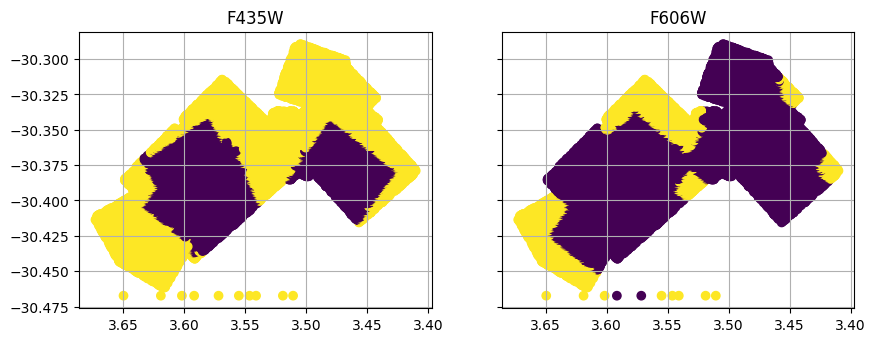

In [10]:
# Missing data are *masked* (?)

# bands in the HFF survey that cover the optical-IR: F435, F606, F814, F105, F140

fig, axes = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)

axes[0].scatter(phot['ra'], phot['dec'], c=phot['f435w_flux_aper_2'].mask)
axes[0].set_title('F435W') # what are (JADES/FRESCO)?
axes[1].scatter(phot['ra'], phot['dec'], c=phot['f606w_flux_aper_2'].mask)
axes[1].set_title('F606W')

axes[0].set_xlim(*axes[0].get_xlim()[::-1])
cosd = np.cos(np.nanmedian(phot['dec'])/180*np.pi)
for ax in axes:
    ax.set_aspect(1./cosd)
    ax.grid()

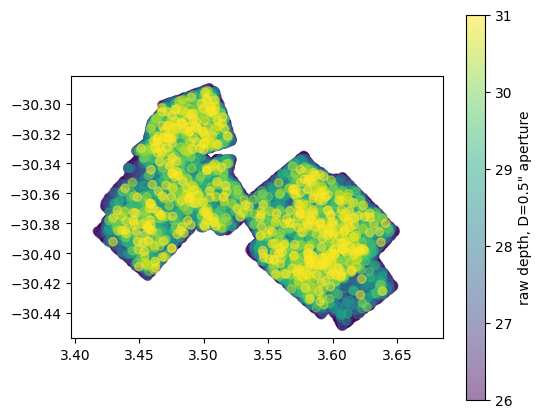

In [51]:
# 5-sigma depth in the D=0.5" aperture
depth = 23.9 - 2.5*np.log10(phot['f606w_flux_aper_2']*5) # how do you get 23.9?
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.set_aspect(1./cosd)
so = np.argsort(depth)
sc = ax.scatter(phot['ra'][so], phot['dec'][so], c=depth[so], vmin=26, vmax=31, alpha=0.5)
ax.set_xlim(*axes[0].get_xlim()[::-1])
cb = plt.colorbar(sc)
cb.set_label('raw depth, D=0.5" aperture')

### Point sources

Text(0, 0.5, 'flux_radius')

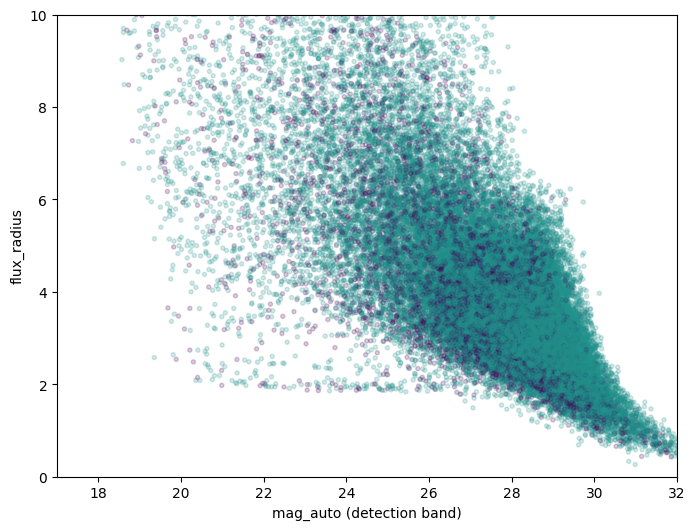

In [67]:
fig, ax = plt.subplots(1,1,figsize=(8, 6))
in_jades = ~phot['f606w_flux_aper_2'].mask
ax.scatter(phot['mag_auto'], phot['flux_radius'], alpha=0.2, c=in_jades, vmin=0, vmax=2, cmap='viridis', marker='.')
ax.set_ylim(0,10); ax.set_xlim(17, 32)

ax.set_xlabel('mag_auto (detection band)'); ax.set_ylabel('flux_radius')


In [73]:
phot.columns

<TableColumns names=('id','thresh','npix','tnpix','xmin','xmax','ymin','ymax','x','y','x2_image','y2_image','xy_image','errx2','erry2','errxy','a_image','b_image','theta_image','cxx_image','cyy_image','cxy_image','cflux','flux','cpeak','peak','xcpeak','ycpeak','xpeak','ypeak','flag','x_image','y_image','number','ra','dec','x_world','y_world','flux_iso','fluxerr_iso','area_iso','mag_iso','kron_radius','kron_rcirc','flux_auto','fluxerr_auto','bkg_auto','flag_auto','area_auto','flux_radius_flag','flux_radius_20','flux_radius','flux_radius_90','tot_corr','mag_auto','magerr_auto','flux_aper_0','fluxerr_aper_0','flag_aper_0','bkg_aper_0','mask_aper_0','flux_aper_1','fluxerr_aper_1','flag_aper_1','bkg_aper_1','mask_aper_1','flux_aper_2','fluxerr_aper_2','flag_aper_2','bkg_aper_2','mask_aper_2','flux_aper_3','fluxerr_aper_3','flag_aper_3','bkg_aper_3','mask_aper_3','clearp-f356w_flux_aper_0','clearp-f356w_fluxerr_aper_0','clearp-f356w_flag_aper_0','clearp-f356w_bkg_aper_0','clearp-f356w_mask_a

## Some random plots

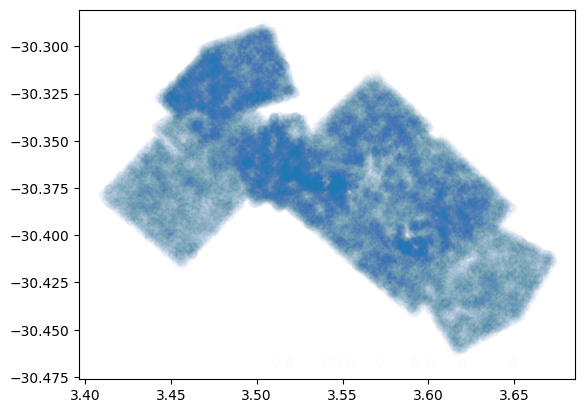

In [13]:
# RA vs Dec
plt.scatter(phot['ra'], phot['dec'], vmin=3.4, vmax=3.6, alpha=0.01)
# plt.scatter(phot['x_world'], phot['y_world'], vmin=3.4, vmax=3.6, alpha=0.01) # <-- celestial coordinates

(-10.0, 250.0)

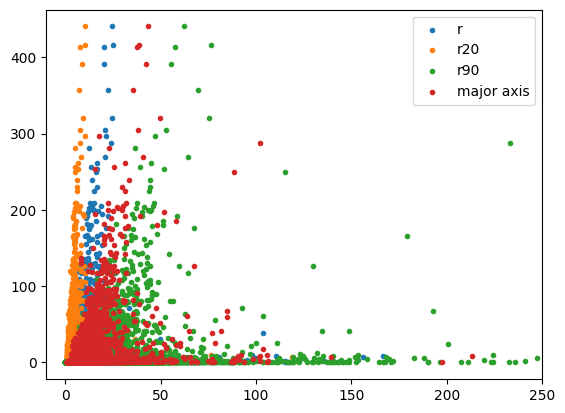

In [38]:
# Flux vs major axis of image (what is the flux radius variable?) r enclosing 50% of flux?
plt.scatter(phot['flux_radius'], phot['flux'], alpha=1, label='r', marker='.')
plt.scatter(phot['flux_radius_20'], phot['flux'], alpha=1, label='r20', marker='.')
plt.scatter(phot['flux_radius_90'], phot['flux'], alpha=1, label='r90', marker='.')
plt.scatter(phot['a_image'], phot['flux'], alpha=1, label='major axis', marker='.')
plt.legend()
plt.xlim(-10, 250)

Kron claims that you capture most of the galaxy flux (>90%) if you use an aperture size twice the radius of the first image moment radius. (kron-like?)

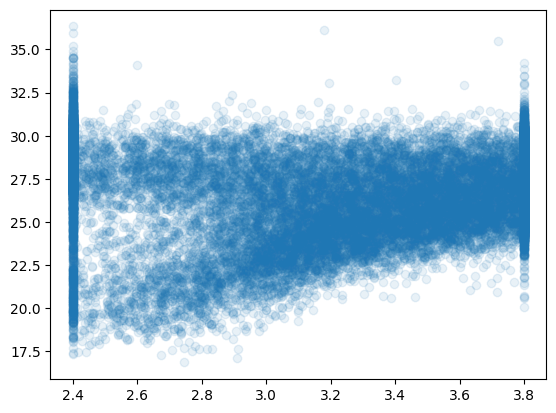

In [109]:
# Magnitude (Kron-like aperture magnitude) vs Kron radius (radius of an aperture w specific fraction of flux)
plt.scatter(phot['kron_radius'], phot['mag_auto'], alpha=0.1)

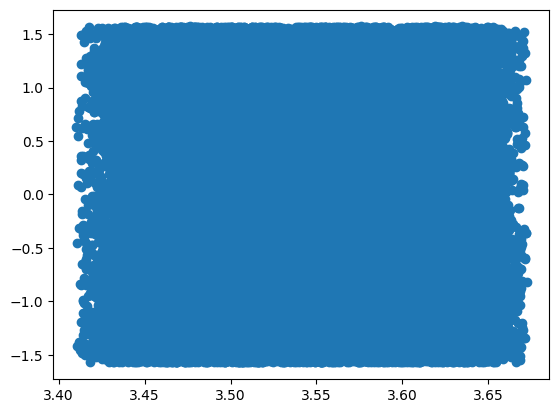

In [18]:
# Orientation as a function of distance (this looks wrong) ?
plt.scatter(phot['ra'], phot['theta_image'])

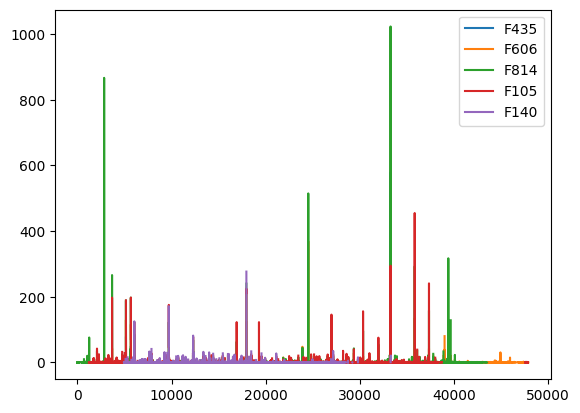

In [16]:
plt.plot(phot['f435w_flux_aper_0'], label='F435')
plt.plot(phot['f606w_flux_aper_0'], label='F606')
plt.plot(phot['f814w_flux_aper_0'], label='F814')
plt.plot(phot['f105w_flux_aper_0'], label='F105')
plt.plot(phot['f140w_flux_aper_0'], label='F140')
plt.legend()

In [31]:
# Variables
# phot['xmin']